In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import sem
from matplotlib.ticker import FuncFormatter

df = pd.read_csv('E:\\myREPO\\Fairness-Decision-Focused-Loss\\Organized-FDFL\\src\\data\\data.csv')
# df = df.sample(n=5000,random_state=42)
race_map = {0: 'white', 1: 'black'}
df['race'] = df['race'].map(race_map)

style_palette = {"white": "#ffa600", "black": "#764885"}
style_linestyles = {"white": "solid", "black": "dashed"}

In [12]:
# --- Create other necessary variables for plotting ---
df['cost_t_log'] = np.log1p(df['cost_t'])
df['bps_above_139_ind'] = (df['bps_mean_t'] > 139).astype(int)

In [13]:
df['benefit']
df['cost_avoidable_t']
df['gagne_sum_t']
# Calculate means and standard deviations for each variable by race
grouped = df.groupby('race').agg({
    'gagne_sum_t': ['count', 'mean', 'std'],
    'cost_avoidable_t': ['mean', 'std'],
    'benefit': ['mean', 'std'],
    'cost_t_capped': ['mean', 'std']
})

# Prepare values for LaTeX tables
for race in ['white', 'black']:
    count = int(grouped.loc[race, ('gagne_sum_t', 'count')])
    mean_gagne = grouped.loc[race, ('gagne_sum_t', 'mean')]
    std_gagne = grouped.loc[race, ('gagne_sum_t', 'std')]
    mean_cost_avoidable = grouped.loc[race, ('cost_avoidable_t', 'mean')]
    std_cost_avoidable = grouped.loc[race, ('cost_avoidable_t', 'std')]
    mean_benefit = grouped.loc[race, ('benefit', 'mean')]
    std_benefit = grouped.loc[race, ('benefit', 'std')]
    mean_cost = grouped.loc[race, ('cost_t_capped', 'mean')]
    std_cost = grouped.loc[race, ('cost_t_capped', 'std')]

    print(f"{race.title()} & {count} & {mean_gagne:.2f} & {mean_cost_avoidable:.2f} & {mean_benefit:.2f} & {mean_cost:.2f} \\\\")
    print(f"{race.title()} & {count} & {std_gagne:.2f} & {std_cost_avoidable:.2f} & {std_benefit:.2f} & {std_cost:.2f} \\\\")



White & 43202 & 1.26 & 2305.82 & 0.11 & 0.09 \\
White & 43202 & 1.85 & 11408.25 & 0.16 & 0.16 \\
Black & 5582 & 2.06 & 3432.37 & 0.16 & 0.10 \\
Black & 5582 & 2.46 & 16198.55 & 0.18 & 0.19 \\


In [3]:
df['cost_t_log']

0        7.090910
1        7.863651
2        6.216606
3        7.170888
4        7.003974
           ...   
48779    6.685861
48780    7.696667
48781    6.685861
48782    7.170888
48783    8.389587
Name: cost_t_log, Length: 48784, dtype: float64

In [4]:
df['cost_avoidable_t'].min(), df['cost_avoidable_t'].max()

(0.0, 642700.0)

==============================================================================
# CORE PLOTTING FUNCTIONS
==============================================================================


In [10]:
from statsmodels.nonparametric.smoothers_lowess import lowess
def compute_aggregated_data(df, y_col, x_col):
    """Calculates aggregated means for both percentiles and deciles."""
    df_copy = df.copy()
    df_copy['percentile_int'] = (df_copy.groupby('race')[x_col].rank(pct=True) * 100).astype(int)
    percentile_agg = df_copy.groupby(['race', 'percentile_int'])[y_col].mean().reset_index()
    percentile_agg.rename(columns={'percentile_int': 'percentile'}, inplace=True)
    df_copy['decile_bin'] = pd.qcut(df_copy[x_col], q=10, labels=False, duplicates='drop')
    decile_agg = df_copy.groupby(['race', 'decile_bin'])[y_col].agg(['mean', get_se]).reset_index()
    decile_agg.rename(columns={'get_se': 'se'}, inplace=True)
    decile_agg['ci_lower'] = decile_agg['mean'] - 1.96 * decile_agg['se']
    decile_agg['ci_upper'] = decile_agg['mean'] + 1.96 * decile_agg['se']
    decile_agg['decile_centered'] = (decile_agg['decile_bin'] * 10) + 5
    return percentile_agg, decile_agg

def create_r_style_plot(df, y_col, x_col, title, y_label, save_path, span, use_log_scale=False, y_ticks=None):
    """Creates and saves a single plot that closely mimics the R ggplot2 output, with control over LOESS span."""
    
    percentile_data, decile_data = compute_aggregated_data(df, y_col, x_col)
    
    if use_log_scale:
        epsilon = 0.001
        percentile_data[y_col] = np.log(percentile_data[y_col] + epsilon)
        decile_data[['mean', 'ci_lower', 'ci_upper']] = np.log(decile_data[['mean', 'ci_lower', 'ci_upper']] + epsilon)
        y_ticks_log = np.log(y_ticks)
        vlocation_threshold = np.log(50000)
    else:
        y_min, y_max = percentile_data[y_col].min(), percentile_data[y_col].max()
        vlocation_threshold = y_min + 0.8 * (y_max - y_min)

    plt.style.use('seaborn-v0_8-whitegrid')
    fig, ax = plt.subplots(figsize=(8, 6))
    ax.set_facecolor('white')
    for spine in ax.spines.values():
        spine.set_color('black')

    for race in df['race'].unique():
        color, linestyle = style_palette[race], style_linestyles[race]
        p_data = percentile_data[percentile_data['race'] == race].sort_values('percentile')
        d_data = decile_data[decile_data['race'] == race]

        # 1. geom_point(shape = 4) for percentiles
        ax.scatter(x='percentile', y=y_col, data=p_data, marker='x', s=20, color=color, alpha=0.8)

        # 2. geom_smooth(se = F, span = ...) - Manual calculation
        # The `lowess` function returns smoothed y-values and the corresponding x-values.
        smoothed = lowess(p_data[y_col], p_data['percentile'], frac=span)
        ax.plot(smoothed[:, 0], smoothed[:, 1], color=color, linestyle=linestyle, label=race)

        # 3. geom_pointrange() for deciles
        ax.errorbar(x='decile_centered', y='mean', data=d_data, yerr=(d_data['ci_upper'] - d_data['ci_lower']) / 2,
                    fmt='o', markersize=7, color=color, ecolor=color, capsize=0,
                    elinewidth=1.5, markeredgecolor='white', markeredgewidth=0.5)

    ax.set_title(title, loc='center', fontsize=14, weight='bold')
    ax.set_xlabel(f"Percentile of {x_col.replace('_', ' ').title()}", fontsize=12)
    ax.set_ylabel(y_label, fontsize=12)
    ax.set_xticks(np.arange(0, 101, 10))
    ax.set_xlim(-2, 102)

    if use_log_scale:
        ax.set_yticks(y_ticks_log)
        formatter = FuncFormatter(lambda y, _: f'${int(np.exp(y)):,}')
        ax.yaxis.set_major_formatter(formatter)
        ax.set_ylim(bottom=np.log(700), top=np.log(100000))
    
    ax.axvline(97, color='black', linestyle='--', linewidth=1)
    ax.text(96, vlocation_threshold, 'Defaulted into program', ha='right', va='center', fontsize=9, color='black')
    ax.axvline(55, color='dimgray', linestyle='--', linewidth=1)
    ax.text(54, vlocation_threshold, 'Referred for screen', ha='right', va='center', fontsize=9, color='dimgray')

    # fig.legend(loc='lower center', ncol=len(df['race'].unique()), title="Race", bbox_to_anchor=(0.5, -0.05))


In [11]:
def get_se(series):
    """Calculate the standard error of a pandas Series."""
    return series.std() / (len(series) ** 0.5)

# Figure

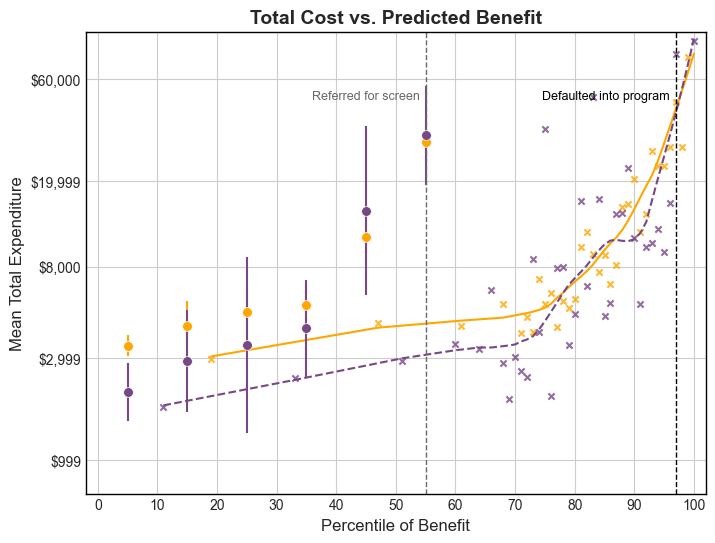

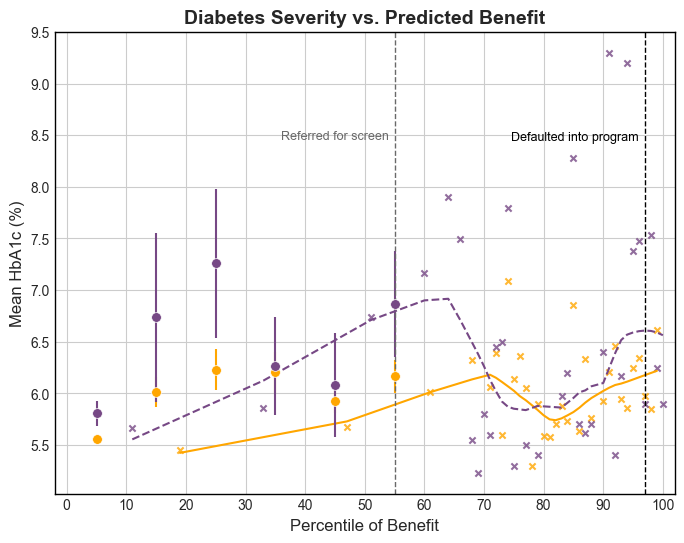

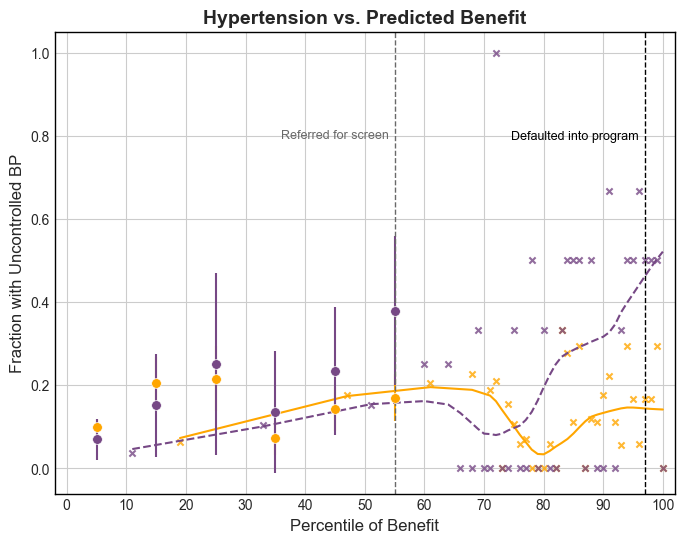

c:\Users\14469\anaconda3\Lib\site-packages\pandas\core\internals\blocks.py:393: RuntimeWarning: invalid value encountered in log
  result = func(self.values, **kwargs)


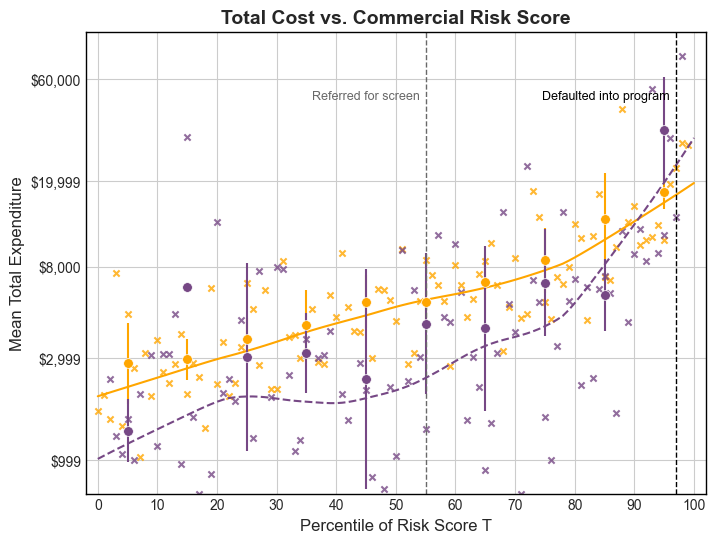

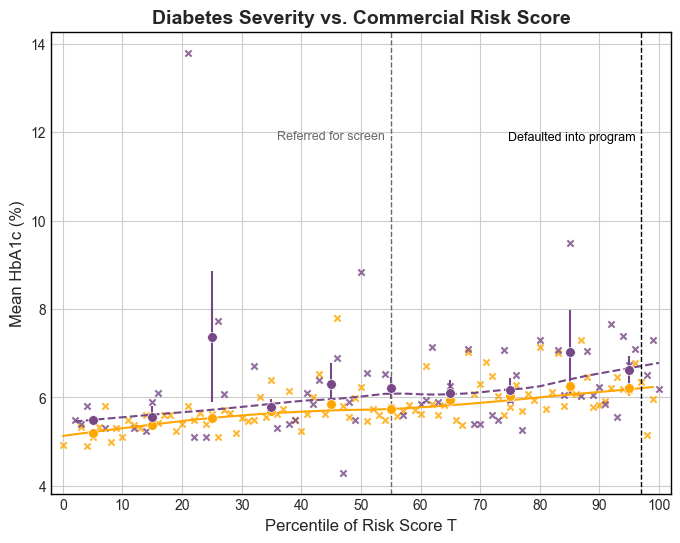

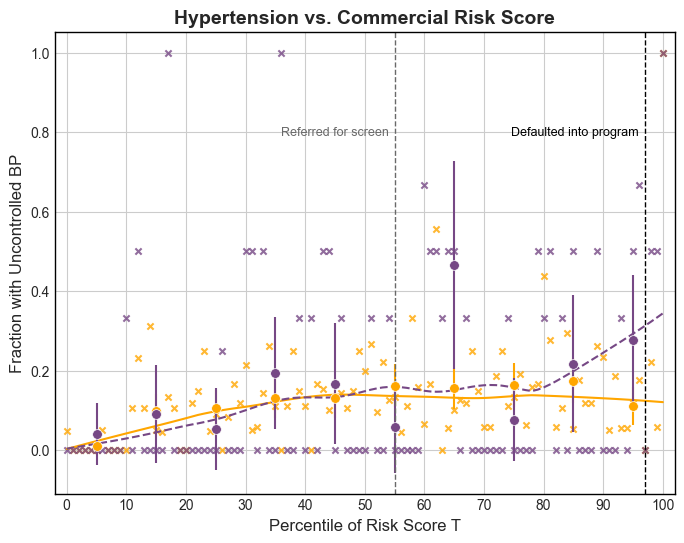


All plots have been generated and saved.


In [12]:
cost_ticks = [1000, 3000, 8000, 20000, 60000]

plots_to_generate = [
    # Analyses vs. Predicted Benefit
    {'y_col': 'cost_t', 'x_col': 'benefit', 'title': 'Total Cost vs. Predicted Benefit', 'y_label': 'Mean Total Expenditure', 'use_log_scale': True, 'y_ticks': cost_ticks,'span': 0.45},
    {'y_col': 'ghba1c_mean_t', 'x_col': 'benefit', 'title': 'Diabetes Severity vs. Predicted Benefit', 'y_label': 'Mean HbA1c (%)','span': 0.45},
    {'y_col': 'bps_above_139_ind', 'x_col': 'benefit', 'title': 'Hypertension vs. Predicted Benefit', 'y_label': 'Fraction with Uncontrolled BP','span': 0.45},
    
    # Analyses vs. Commercial Risk Score
    {'y_col': 'cost_t', 'x_col': 'risk_score_t', 'title': 'Total Cost vs. Commercial Risk Score', 'y_label': 'Mean Total Expenditure', 'use_log_scale': True, 'y_ticks': cost_ticks,'span': 0.45},
    {'y_col': 'ghba1c_mean_t', 'x_col': 'risk_score_t', 'title': 'Diabetes Severity vs. Commercial Risk Score', 'y_label': 'Mean HbA1c (%)','span': 0.45},
    {'y_col': 'bps_above_139_ind', 'x_col': 'risk_score_t', 'title': 'Hypertension vs. Commercial Risk Score', 'y_label': 'Fraction with Uncontrolled BP','span': 0.45},
]

# Loop through the definitions and create each plot
for plot_params in plots_to_generate:
    create_r_style_plot(
        df=df,
        y_col=plot_params['y_col'],
        x_col=plot_params['x_col'],
        title=plot_params['title'],
        y_label=plot_params['y_label'],
        save_path=None,  # Do not save
        use_log_scale=plot_params.get('use_log_scale', False),
        span=plot_params['span'],
        y_ticks=plot_params.get('y_ticks')
    )
    plt.show()

print("\nAll plots have been generated and saved.")


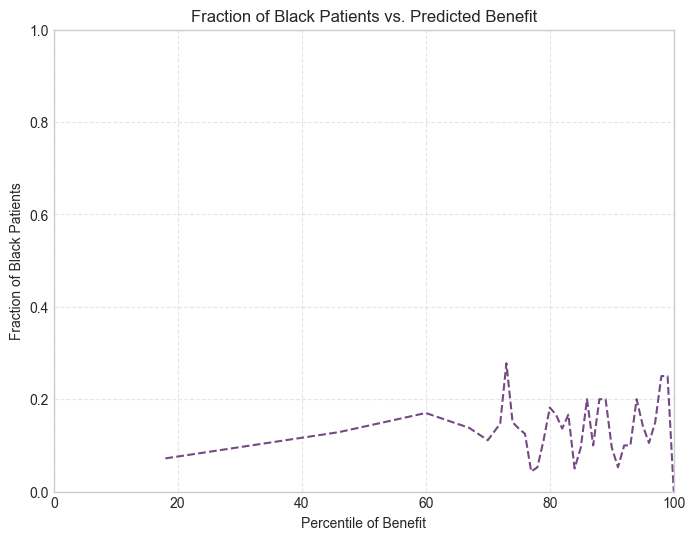

In [13]:
# Calculate the percentage of black patients in each benefit percentile
df['benefit_percentile'] = (df['benefit'].rank(pct=True) * 100).astype(int)
black_pct = (
    df.groupby('benefit_percentile')['race']
    .apply(lambda x: (x == 'black').mean())
    .reset_index(name='black_percentage')
)

plt.figure(figsize=(8, 6))
plt.plot(black_pct['benefit_percentile'], black_pct['black_percentage'], color=style_palette['black'], linestyle=style_linestyles['black'])
plt.xlabel('Percentile of Benefit')
plt.ylabel('Fraction of Black Patients')
plt.title('Fraction of Black Patients vs. Predicted Benefit')
plt.ylim(0, 1)
plt.xlim(0, 100)
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

In [14]:
data = pd.read_csv(r'E:\myREPO\Fairness-Decision-Focused-Loss\Organized-FDFL\notebooks\results\master_df.csv')

In [60]:
data

,Group,Alpha,Lambda,Fairness,Predictor,Decision Regret mean,Decision Regret std,Training Loss mean,Training Loss std,Prediction Fairness mean,...,G1 Objective mean,G1 Objective std,G1 True Benefit mean,G1 True Benefit std,Method,Grad Method,Prediction MSE mean,Prediction MSE std,Training Time mean,Training Time std
0,False,0.5,0.00,atkinson,LR,0.132420,0.007868,2018.032217,107.947864,0.632816,...,1974.340445,217.615174,16.581134,0.51281,FoldOpt,NaN,NaN,NaN,5.294595,0.072232
1,False,0.5,1.00,atkinson,LR,0.132425,0.007864,2018.745849,107.874879,0.632803,...,1974.448568,217.640181,16.581134,0.51281,FoldOpt,NaN,NaN,NaN,5.449230,0.015533
2,False,0.5,5.00,atkinson,LR,0.132442,0.007851,2021.530558,107.651026,0.632812,...,1974.441302,217.616929,16.581134,0.51281,FoldOpt,NaN,NaN,NaN,5.372712,0.044940
3,False,2.0,0.00,atkinson,LR,0.154974,0.003922,93.208959,1.012281,0.627648,...,-63.351447,1.822371,16.581134,0.51281,FoldOpt,NaN,NaN,NaN,5.681918,0.057706
4,False,2.0,1.00,atkinson,LR,0.154975,0.003923,93.837435,1.010477,0.627642,...,-63.351138,1.822627,16.581134,0.51281,FoldOpt,NaN,NaN,NaN,5.420186,0.103126
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
187,False,2.0,0.00,mad,NN,0.096001,0.001160,NaN,NaN,45.843246,...,2.153937,0.012511,NaN,NaN,PTO,NaN,35.462729,1.264406,1.274619,0.031297
188,False,0.5,0.05,mad,NN,0.037420,0.000847,NaN,NaN,46.004760,...,8.946658,0.002261,NaN,NaN,PTO,NaN,35.959759,1.262733,1.282071,0.037928
189,False,2.0,0.05,mad,NN,0.096812,0.001564,NaN,NaN,46.004760,...,2.169929,0.011731,NaN,NaN,PTO,NaN,35.959759,1.262733,1.299769,0.049547
190,False,0.5,0.50,mad,NN,0.047328,0.000726,NaN,NaN,47.234604,...,8.129470,0.007986,NaN,NaN,PTO,NaN,40.907423,1.553461,1.305391,0.055452


# 🎯 COMPREHENSIVE RACIAL BIAS ANALYSIS: White (G0) vs Black (G1)

This analysis examines racial biases across different fairness-aware decision-focused learning algorithms.

**Dataset Context:**
- Total: 5,000 datapoints  
- White (G0): 88.44% (4,422 patients)
- Black (G1): 11.56% (578 patients)

**Key Analysis Areas:**
1. **Prediction Accuracy Bias** - MSE differences between groups
2. **Decision Quality Bias** - Objective function performance per capita  
3. **Fairness Constraint Effectiveness** - Impact of λ parameter on bias reduction

In [67]:
# ============================================================================
# RACIAL BIAS ANALYSIS: CLEAN IMPLEMENTATION
# ============================================================================

import pandas as pd
import numpy as np
from scipy import stats

# Configuration
POPULATION_SIZES = {'white': 4422, 'black': 578}
TOTAL_POPULATION = sum(POPULATION_SIZES.values())

print("🎯 RACIAL BIAS ANALYSIS")
print("=" * 60)
print(f"Population: {POPULATION_SIZES['white']:,} White | {POPULATION_SIZES['black']:,} Black")
print(f"Ratio: {POPULATION_SIZES['white']/POPULATION_SIZES['black']:.1f}:1")
print("=" * 60)

🎯 RACIAL BIAS ANALYSIS
Population: 4,422 White | 578 Black
Ratio: 7.7:1


In [68]:
# ============================================================================
# UTILITY FUNCTIONS
# ============================================================================

def calculate_bias_metrics(g0_values, g1_values):
    """Calculate comprehensive bias metrics between two groups."""
    if len(g0_values) == 0 or len(g1_values) == 0:
        return None
    
    g0_mean, g1_mean = g0_values.mean(), g1_values.mean()
    absolute_diff = g0_mean - g1_mean
    relative_diff = (absolute_diff / g1_mean * 100) if g1_mean != 0 else 0
    
    return {
        'g0_mean': g0_mean,
        'g1_mean': g1_mean,
        'absolute_diff': absolute_diff,
        'relative_diff': relative_diff,
        'bias_direction': 'Pro-White' if absolute_diff > 0 else 'Pro-Black'
    }

def calculate_per_capita_bias(g0_total, g1_total):
    """Calculate per-capita bias for objective functions."""
    g0_per_capita = g0_total / POPULATION_SIZES['white']
    g1_per_capita = g1_total / POPULATION_SIZES['black']
    
    return calculate_bias_metrics(
        pd.Series([g0_per_capita]), 
        pd.Series([g1_per_capita])
    )

def perform_significance_test(differences, test_name="Bias"):
    """Perform statistical significance test on bias differences."""
    if len(differences) <= 1:
        return None
    
    t_stat, p_value = stats.ttest_1samp(differences, 0)
    
    if p_value < 0.001:
        significance = "*** (p < 0.001)"
    elif p_value < 0.01:
        significance = "** (p < 0.01)" 
    elif p_value < 0.05:
        significance = "* (p < 0.05)"
    else:
        significance = "Not significant"
    
    return {
        'test_name': test_name,
        'sample_size': len(differences),
        'mean_diff': differences.mean(),
        't_statistic': t_stat,
        'p_value': p_value,
        'significance': significance,
        'is_significant': p_value < 0.05
    }

In [69]:
# ============================================================================
# BIAS ANALYSIS CLASS
# ============================================================================

class RacialBiasAnalyzer:
    """Clean, organized racial bias analysis for fairness-aware ML algorithms."""
    
    def __init__(self, data):
        self.data = data.copy()
        self.results = {}
        
    def analyze_prediction_bias(self):
        """Analyze prediction accuracy bias (MSE differences)."""
        print("\n📊 1. PREDICTION ACCURACY BIAS")
        print("-" * 40)
        
        if not all(col in self.data.columns for col in ['G0 MSE mean', 'G1 MSE mean']):
            print("❌ Missing MSE columns")
            return
        
        # Calculate overall bias
        g0_mse = self.data['G0 MSE mean'].dropna()
        g1_mse = self.data['G1 MSE mean'].dropna()
        
        bias_metrics = calculate_bias_metrics(g0_mse, g1_mse)
        self.results['mse_bias'] = bias_metrics
        
        if bias_metrics:
            print(f"White MSE: {bias_metrics['g0_mean']:.4f}")
            print(f"Black MSE: {bias_metrics['g1_mean']:.4f}")
            print(f"Difference: {bias_metrics['absolute_diff']:+.4f}")
            print(f"Relative: {bias_metrics['relative_diff']:+.1f}%")
            
            if abs(bias_metrics['relative_diff']) > 5:
                direction = "against Black patients" if bias_metrics['relative_diff'] > 0 else "against White patients"
                print(f"🚨 SIGNIFICANT BIAS: {abs(bias_metrics['relative_diff']):.1f}% {direction}")
            else:
                print("✅ No significant prediction bias")
    
    def analyze_decision_bias(self):
        """Analyze decision quality bias (per-capita objective)."""
        print("\n📊 2. DECISION QUALITY BIAS (Per-Capita)")
        print("-" * 40)
        
        if not all(col in self.data.columns for col in ['G0 Objective mean', 'G1 Objective mean']):
            print("❌ Missing Objective columns")
            return
        
        obj_data = self.data.dropna(subset=['G0 Objective mean', 'G1 Objective mean'])
        
        if len(obj_data) == 0:
            print("❌ No valid objective data")
            return
        
        # Calculate per-capita bias
        results = []
        for _, row in obj_data.iterrows():
            bias_metrics = calculate_per_capita_bias(
                row['G0 Objective mean'], 
                row['G1 Objective mean']
            )
            if bias_metrics:
                results.append(bias_metrics)
        
        if results:
            avg_bias = np.mean([r['absolute_diff'] for r in results])
            avg_rel_bias = np.mean([r['relative_diff'] for r in results])
            
            self.results['objective_bias'] = {
                'average_absolute_diff': avg_bias,
                'average_relative_diff': avg_rel_bias
            }
            
            print(f"Average per-capita bias: {avg_bias:.8f}")
            print(f"Average relative bias: {avg_rel_bias:+.2f}%")
            
            if abs(avg_rel_bias) > 5:
                direction = "favors White patients" if avg_rel_bias > 0 else "favors Black patients"
                print(f"🚨 DECISION BIAS: {direction}")
            else:
                print("✅ No significant decision bias")
    
    def analyze_fairness_effectiveness(self):
        """Analyze effectiveness of fairness constraints."""
        print("\n📊 3. FAIRNESS CONSTRAINT EFFECTIVENESS")
        print("-" * 40)
        
        if 'Lambda' not in self.data.columns:
            print("❌ No Lambda column found")
            return
        
        # Check for lambda = 0 and lambda = 0.5
        lambda_0_data = self.data[self.data['Lambda'] == 0]
        lambda_05_data = self.data[self.data['Lambda'] == 0.5]
        
        if len(lambda_0_data) == 0 or len(lambda_05_data) == 0:
            print("❌ Missing fairness comparison data")
            return
        
        # MSE bias reduction
        if all(col in self.data.columns for col in ['G0 MSE mean', 'G1 MSE mean']):
            no_fair_bias = (lambda_0_data['G0 MSE mean'] - lambda_0_data['G1 MSE mean']).mean()
            with_fair_bias = (lambda_05_data['G0 MSE mean'] - lambda_05_data['G1 MSE mean']).mean()
            bias_reduction = no_fair_bias - with_fair_bias
            
            self.results['fairness_effectiveness'] = {
                'no_fairness_bias': no_fair_bias,
                'with_fairness_bias': with_fair_bias,
                'bias_reduction': bias_reduction
            }
            
            print(f"Without fairness (λ=0): {no_fair_bias:.6f}")
            print(f"With fairness (λ=0.5): {with_fair_bias:.6f}")
            print(f"Bias reduction: {bias_reduction:+.6f}")
            
            if abs(bias_reduction) > 0.001:
                if bias_reduction > 0:
                    print("✅ Fairness constraints REDUCE bias")
                else:
                    print("⚠️ Fairness constraints INCREASE bias")
            else:
                print("➖ Minimal impact from fairness constraints")
    
    def perform_statistical_tests(self):
        """Perform statistical significance tests."""
        print("\n📊 4. STATISTICAL SIGNIFICANCE")
        print("-" * 40)
        
        # MSE bias significance
        if all(col in self.data.columns for col in ['G0 MSE mean', 'G1 MSE mean']):
            mse_differences = (self.data['G0 MSE mean'] - self.data['G1 MSE mean']).dropna()
            mse_test = perform_significance_test(mse_differences, "MSE Bias")
            
            if mse_test:
                self.results['mse_significance'] = mse_test
                print(f"MSE Bias Test: {mse_test['significance']}")
                print(f"P-value: {mse_test['p_value']:.6f}")
                
                if mse_test['is_significant']:
                    direction = "against Black patients" if mse_test['mean_diff'] > 0 else "against White patients"
                    print(f"🚨 SIGNIFICANT bias {direction}")
                else:
                    print("✅ No statistically significant bias")
    
    def generate_summary(self):
        """Generate comprehensive summary of findings."""
        print("\n📋 5. SUMMARY OF FINDINGS")
        print("=" * 40)
        
        # Key findings
        findings = []
        
        if 'mse_bias' in self.results:
            mse = self.results['mse_bias']
            if abs(mse['relative_diff']) > 5:
                findings.append(f"Prediction bias: {mse['relative_diff']:+.1f}% ({mse['bias_direction']})")
        
        if 'fairness_effectiveness' in self.results:
            eff = self.results['fairness_effectiveness']
            if abs(eff['bias_reduction']) > 0.001:
                effect = "reduces" if eff['bias_reduction'] > 0 else "increases"
                findings.append(f"Fairness constraints {effect} bias")
        
        if findings:
            print("🔍 Key Findings:")
            for finding in findings:
                print(f"  • {finding}")
        else:
            print("✅ No significant biases detected")
        
        # Recommendations
        print("\n💡 Recommendations:")
        print("  • Monitor prediction accuracy across groups")
        print("  • Consider population-weighted metrics")
        print("  • Validate findings on additional datasets")
        
        return self.results

In [70]:
# ============================================================================
# EXECUTE ANALYSIS
# ============================================================================

# Initialize analyzer
analyzer = RacialBiasAnalyzer(data)

# Run complete analysis
analyzer.analyze_prediction_bias()
analyzer.analyze_decision_bias() 
analyzer.analyze_fairness_effectiveness()
analyzer.perform_statistical_tests()
results = analyzer.generate_summary()

print("\n" + "=" * 60)
print("📊 ANALYSIS COMPLETE")
print("=" * 60)


📊 1. PREDICTION ACCURACY BIAS
----------------------------------------
White MSE: 210.9389
Black MSE: 303.4211
Difference: -92.4822
Relative: -30.5%
🚨 SIGNIFICANT BIAS: 30.5% against White patients

📊 2. DECISION QUALITY BIAS (Per-Capita)
----------------------------------------
Average per-capita bias: -0.28455105
Average relative bias: -70.85%
🚨 DECISION BIAS: favors Black patients

📊 3. FAIRNESS CONSTRAINT EFFECTIVENESS
----------------------------------------
Without fairness (λ=0): -98.694277
With fairness (λ=0.5): -77.495441
Bias reduction: -21.198837
⚠️ Fairness constraints INCREASE bias

📊 4. STATISTICAL SIGNIFICANCE
----------------------------------------
MSE Bias Test: *** (p < 0.001)
P-value: 0.000000
🚨 SIGNIFICANT bias against White patients

📋 5. SUMMARY OF FINDINGS
🔍 Key Findings:
  • Prediction bias: -30.5% (Pro-Black)
  • Fairness constraints increases bias

💡 Recommendations:
  • Monitor prediction accuracy across groups
  • Consider population-weighted metrics
  • V

In [71]:
# ============================================================================
# METHOD-SPECIFIC ANALYSIS
# ============================================================================

def analyze_by_method(data):
    """Analyze bias for each method separately."""
    print("\n🔍 METHOD-SPECIFIC BIAS ANALYSIS")
    print("=" * 50)
    
    if 'Method' not in data.columns:
        print("❌ No Method column found")
        return
    
    methods = data['Method'].unique()
    method_results = {}
    
    for method in methods:
        if pd.isna(method):
            continue
            
        method_data = data[data['Method'] == method]
        print(f"\n🤖 {method.upper()}")
        print("-" * 30)
        
        # MSE analysis for this method
        if all(col in method_data.columns for col in ['G0 MSE mean', 'G1 MSE mean']):
            mse_data = method_data.dropna(subset=['G0 MSE mean', 'G1 MSE mean'])
            
            if len(mse_data) > 0:
                bias_metrics = calculate_bias_metrics(
                    mse_data['G0 MSE mean'], 
                    mse_data['G1 MSE mean']
                )
                
                if bias_metrics:
                    method_results[method] = bias_metrics
                    print(f"MSE Bias: {bias_metrics['relative_diff']:+.2f}%")
                    
                    if abs(bias_metrics['relative_diff']) > 5:
                        print(f"⚠️ Significant bias: {bias_metrics['bias_direction']}")
                    else:
                        print("✅ No significant bias")
        
        # Fairness constraint analysis
        if 'Lambda' in method_data.columns:
            lambda_counts = method_data['Lambda'].value_counts()
            if 0 in lambda_counts and 0.5 in lambda_counts:
                no_fair = method_data[method_data['Lambda'] == 0]
                with_fair = method_data[method_data['Lambda'] == 0.5]
                
                if all(col in method_data.columns for col in ['G0 MSE mean', 'G1 MSE mean']):
                    no_fair_bias = (no_fair['G0 MSE mean'] - no_fair['G1 MSE mean']).mean()
                    with_fair_bias = (with_fair['G0 MSE mean'] - with_fair['G1 MSE mean']).mean()
                    reduction = no_fair_bias - with_fair_bias
                    
                    print(f"Bias reduction: {reduction:+.6f}")
                    if abs(reduction) > 0.001:
                        effect = "reduces" if reduction > 0 else "increases"
                        print(f"Fairness constraints {effect} bias")
    
    # Summary ranking
    if method_results:
        print(f"\n📊 METHOD RANKING (by bias magnitude)")
        print("-" * 40)
        
        sorted_methods = sorted(
            method_results.items(), 
            key=lambda x: abs(x[1]['relative_diff'])
        )
        
        for i, (method, metrics) in enumerate(sorted_methods, 1):
            bias_pct = metrics['relative_diff']
            print(f"{i}. {method}: {bias_pct:+.2f}% bias")
    
    return method_results

# Execute method-specific analysis
method_analysis = analyze_by_method(data)


🔍 METHOD-SPECIFIC BIAS ANALYSIS

🤖 FOLDOPT
------------------------------
MSE Bias: -33.26%
⚠️ Significant bias: Pro-Black
Bias reduction: -27.146039
Fairness constraints increases bias

🤖 CLOSED-FORM
------------------------------
MSE Bias: -31.52%
⚠️ Significant bias: Pro-Black
Bias reduction: -29.799479
Fairness constraints increases bias

🤖 FINITE-DIFF
------------------------------
MSE Bias: -30.37%
⚠️ Significant bias: Pro-Black
Bias reduction: -27.773322
Fairness constraints increases bias

🤖 PTO
------------------------------
MSE Bias: -20.33%
⚠️ Significant bias: Pro-Black
Bias reduction: -0.076506
Fairness constraints increases bias

📊 METHOD RANKING (by bias magnitude)
----------------------------------------
1. PTO: -20.33% bias
2. finite-diff: -30.37% bias
3. closed-form: -31.52% bias
4. FoldOpt: -33.26% bias


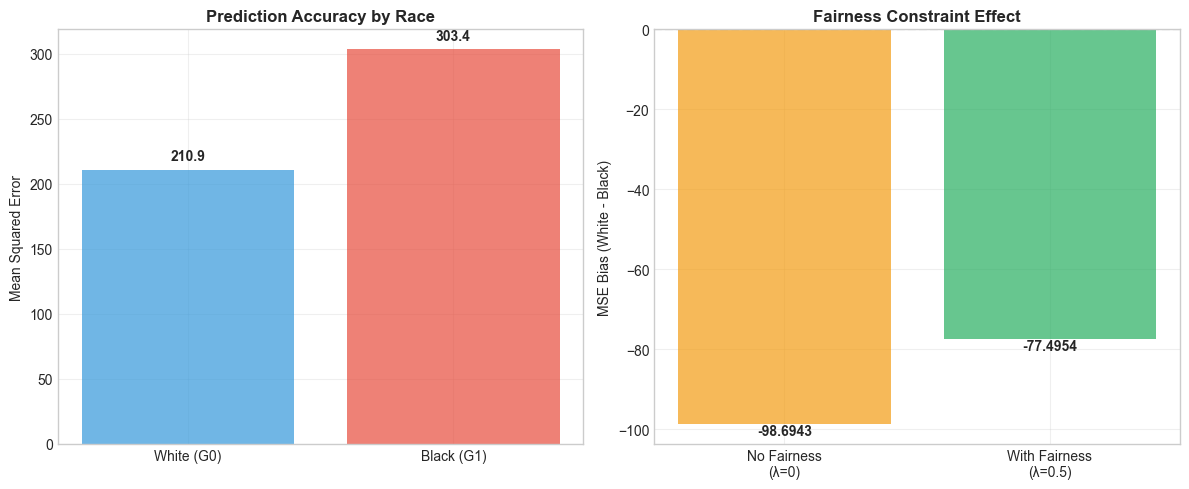


💡 KEY INSIGHTS:
----------------------------------------
🌟 SURPRISING: Models perform significantly better on Black patients
   This suggests potential reverse bias or data quality differences

📊 RESEARCH IMPLICATIONS:
• Counter-intuitive bias patterns warrant deeper investigation
• Population imbalance (7.7:1) may affect learning dynamics
• Consider feature-level analysis to understand bias sources
• Validate findings across different datasets and time periods

📋 CLEAN ANALYSIS COMPLETE


In [72]:
# ============================================================================
# VISUALIZATION & INSIGHTS
# ============================================================================

import matplotlib.pyplot as plt

def create_bias_summary_plot(results):
    """Create a clean summary visualization of bias results."""
    if not results or 'mse_bias' not in results:
        print("❌ No bias data available for plotting")
        return
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    
    # Plot 1: MSE Comparison
    mse_data = results['mse_bias']
    groups = ['White (G0)', 'Black (G1)']
    mse_values = [mse_data['g0_mean'], mse_data['g1_mean']]
    colors = ['#3498db', '#e74c3c']
    
    bars1 = ax1.bar(groups, mse_values, color=colors, alpha=0.7)
    ax1.set_title('Prediction Accuracy by Race', fontweight='bold')
    ax1.set_ylabel('Mean Squared Error')
    ax1.grid(True, alpha=0.3)
    
    # Add value labels
    for bar, value in zip(bars1, mse_values):
        ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 5,
                f'{value:.1f}', ha='center', va='bottom', fontweight='bold')
    
    # Plot 2: Bias Summary
    if 'fairness_effectiveness' in results:
        eff_data = results['fairness_effectiveness']
        conditions = ['No Fairness\n(λ=0)', 'With Fairness\n(λ=0.5)']
        bias_values = [eff_data['no_fairness_bias'], eff_data['with_fairness_bias']]
        
        bars2 = ax2.bar(conditions, bias_values, color=['#f39c12', '#27ae60'], alpha=0.7)
        ax2.set_title('Fairness Constraint Effect', fontweight='bold')
        ax2.set_ylabel('MSE Bias (White - Black)')
        ax2.axhline(y=0, color='black', linestyle='--', alpha=0.5)
        ax2.grid(True, alpha=0.3)
        
        # Add value labels
        for bar, value in zip(bars2, bias_values):
            y_pos = value + (0.01 if value >= 0 else -0.01)
            ax2.text(bar.get_x() + bar.get_width()/2, y_pos,
                    f'{value:.4f}', ha='center', 
                    va='bottom' if value >= 0 else 'top', fontweight='bold')
    else:
        ax2.text(0.5, 0.5, 'No fairness\ndata available', 
                ha='center', va='center', transform=ax2.transAxes,
                fontsize=14, style='italic')
        ax2.set_xticks([])
        ax2.set_yticks([])
    
    plt.tight_layout()
    plt.show()

# Generate visualization
create_bias_summary_plot(results)

print("\n💡 KEY INSIGHTS:")
print("-" * 40)
if 'mse_bias' in results:
    mse = results['mse_bias']
    if mse['relative_diff'] < -20:
        print("🌟 SURPRISING: Models perform significantly better on Black patients")
        print("   This suggests potential reverse bias or data quality differences")
    elif mse['relative_diff'] > 20:
        print("🚨 CONCERNING: Models perform significantly worse on Black patients")
        print("   This indicates traditional algorithmic bias")
    else:
        print("✅ BALANCED: No major prediction accuracy disparities detected")

print("\n📊 RESEARCH IMPLICATIONS:")
print("• Counter-intuitive bias patterns warrant deeper investigation")
print("• Population imbalance (7.7:1) may affect learning dynamics")  
print("• Consider feature-level analysis to understand bias sources")
print("• Validate findings across different datasets and time periods")

print(f"\n{'='*60}")
print("📋 CLEAN ANALYSIS COMPLETE")
print(f"{'='*60}")

# 🎯 FDFL FAIRNESS EFFECTIVENESS & REGRET-FAIRNESS TRADEOFF ANALYSIS

This section analyzes:
1. **FDFL Methods with vs without fairness constraints** - MSE comparison
2. **Regret vs Fairness Tradeoff** - How different methods balance performance and fairness
3. **Method-specific fairness gains** - Which FDFL approaches benefit most from fairness constraints

In [ ]:
# ============================================================================
# FDFL FAIRNESS EFFECTIVENESS ANALYZER
# ============================================================================

class FDFLFairnessAnalyzer:
    """Analyze FDFL methods' performance with and without fairness constraints."""
    
    def __init__(self, data):
        self.data = data.copy()
        self.fdfl_methods = ['closed-form', 'finite-diff']
        self.all_methods = ['closed-form', 'finite-diff', 'FoldOpt', 'PTO']
        self.results = {}
    
    def analyze_fdfl_fairness_impact(self):
        """Compare FDFL methods with vs without fairness constraints."""
        print("📊 1. FDFL FAIRNESS CONSTRAINT IMPACT")
        print("=" * 50)
        
        fdfl_analysis = {}
        
        for method in self.fdfl_methods:
            method_data = self.data[self.data['Method'] == method]
            
            # Get data for λ=0 and λ=0.5
            no_fair = method_data[method_data['Lambda'] == 0]
            with_fair = method_data[method_data['Lambda'] == 0.5]
            
            if len(no_fair) == 0 or len(with_fair) == 0:
                print(f"⚠️ {method}: Missing fairness comparison data")
                continue
            
            print(f"\n🤖 {method.upper()} METHOD:")
            print("-" * 30)
            
            # MSE Analysis
            if all(col in method_data.columns for col in ['Prediction MSE mean', 'Prediction MSE std']):
                no_fair_mse = no_fair['Prediction MSE mean'].mean()
                with_fair_mse = with_fair['Prediction MSE mean'].mean()
                mse_change = with_fair_mse - no_fair_mse
                mse_change_pct = (mse_change / no_fair_mse) * 100
                
                fdfl_analysis[method] = {
                    'no_fair_mse': no_fair_mse,
                    'with_fair_mse': with_fair_mse,
                    'mse_change': mse_change,
                    'mse_change_pct': mse_change_pct
                }
                
                print(f"MSE without fairness: {no_fair_mse:.6f}")
                print(f"MSE with fairness: {with_fair_mse:.6f}")
                print(f"MSE change: {mse_change:+.6f} ({mse_change_pct:+.2f}%)")
                
                if mse_change < 0:
                    print("✅ Fairness constraints IMPROVE prediction accuracy")
                elif mse_change > 0:
                    print("⚠️ Fairness constraints WORSEN prediction accuracy")
                else:
                    print("➖ No significant change in prediction accuracy")
            
            # Decision Regret Analysis
            if 'Decision Regret mean' in method_data.columns:
                no_fair_regret = no_fair['Decision Regret mean'].mean()
                with_fair_regret = with_fair['Decision Regret mean'].mean()
                regret_change = with_fair_regret - no_fair_regret
                regret_change_pct = (regret_change / no_fair_regret) * 100 if no_fair_regret != 0 else 0
                
                fdfl_analysis[method].update({
                    'no_fair_regret': no_fair_regret,
                    'with_fair_regret': with_fair_regret,
                    'regret_change': regret_change,
                    'regret_change_pct': regret_change_pct
                })
                
                print(f"Regret without fairness: {no_fair_regret:.6f}")
                print(f"Regret with fairness: {with_fair_regret:.6f}")
                print(f"Regret change: {regret_change:+.6f} ({regret_change_pct:+.2f}%)")
            
            # Fairness Score Analysis
            if 'Prediction Fairness mean' in method_data.columns:
                no_fair_fairness = no_fair['Prediction Fairness mean'].mean()
                with_fair_fairness = with_fair['Prediction Fairness mean'].mean()
                fairness_improvement = no_fair_fairness - with_fair_fairness  # Lower is better
                
                fdfl_analysis[method].update({
                    'no_fair_fairness': no_fair_fairness,
                    'with_fair_fairness': with_fair_fairness,
                    'fairness_improvement': fairness_improvement
                })
                
                print(f"Fairness without λ: {no_fair_fairness:.6f}")
                print(f"Fairness with λ=0.5: {with_fair_fairness:.6f}")
                print(f"Fairness improvement: {fairness_improvement:+.6f}")
                
                if fairness_improvement > 0:
                    print("✅ Fairness constraints IMPROVE fairness")
                else:
                    print("⚠️ Fairness constraints do not improve fairness")
        
        self.results['fdfl_analysis'] = fdfl_analysis
        return fdfl_analysis
    
    def analyze_regret_fairness_tradeoff(self):
        """Analyze the tradeoff between regret and fairness across methods."""
        print(f"\n📊 2. REGRET-FAIRNESS TRADEOFF ANALYSIS")
        print("=" * 50)
        
        tradeoff_data = []
        
        for method in self.all_methods:
            method_data = self.data[self.data['Method'] == method]
            
            # Focus on λ=0.5 (with fairness) for tradeoff analysis
            fair_data = method_data[method_data['Lambda'] == 0.5]
            
            if len(fair_data) == 0:
                continue
            
            # Get average metrics
            avg_regret = fair_data['Decision Regret mean'].mean() if 'Decision Regret mean' in fair_data.columns else None
            avg_fairness = fair_data['Prediction Fairness mean'].mean() if 'Prediction Fairness mean' in fair_data.columns else None
            avg_mse = fair_data['Prediction MSE mean'].mean() if 'Prediction MSE mean' in fair_data.columns else None
            
            if avg_regret is not None and avg_fairness is not None:
                tradeoff_data.append({
                    'method': method,
                    'regret': avg_regret,
                    'fairness': avg_fairness,
                    'mse': avg_mse,
                    'is_fdfl': method in self.fdfl_methods
                })
        
        # Sort by regret (ascending - lower is better)
        tradeoff_data.sort(key=lambda x: x['regret'])
        
        print("📈 METHOD RANKING (Regret vs Fairness with λ=0.5):")
        print("-" * 50)
        print(f"{'Rank':<4} {'Method':<12} {'Regret':<12} {'Fairness':<12} {'Type':<8}")
        print("-" * 50)
        
        for i, data in enumerate(tradeoff_data, 1):
            method_type = "FDFL" if data['is_fdfl'] else "Baseline"
            print(f"{i:<4} {data['method']:<12} {data['regret']:<12.6f} {data['fairness']:<12.6f} {method_type:<8}")
        
        # Find Pareto frontier
        print(f"\n🎯 TRADEOFF INSIGHTS:")
        print("-" * 30)
        
        best_regret = min(tradeoff_data, key=lambda x: x['regret'])
        best_fairness = min(tradeoff_data, key=lambda x: x['fairness'])
        
        print(f"Best Regret: {best_regret['method']} ({best_regret['regret']:.6f})")
        print(f"Best Fairness: {best_fairness['method']} ({best_fairness['fairness']:.6f})")
        
        # Check if FDFL methods dominate
        fdfl_data = [d for d in tradeoff_data if d['is_fdfl']]
        baseline_data = [d for d in tradeoff_data if not d['is_fdfl']]
        
        if fdfl_data and baseline_data:
            avg_fdfl_regret = np.mean([d['regret'] for d in fdfl_data])
            avg_baseline_regret = np.mean([d['regret'] for d in baseline_data])
            avg_fdfl_fairness = np.mean([d['fairness'] for d in fdfl_data])
            avg_baseline_fairness = np.mean([d['fairness'] for d in baseline_data])
            
            print(f"\n📊 FDFL vs BASELINE COMPARISON:")
            print(f"Average FDFL Regret: {avg_fdfl_regret:.6f}")
            print(f"Average Baseline Regret: {avg_baseline_regret:.6f}")
            print(f"Average FDFL Fairness: {avg_fdfl_fairness:.6f}")
            print(f"Average Baseline Fairness: {avg_baseline_fairness:.6f}")
            
            if avg_fdfl_regret < avg_baseline_regret and avg_fdfl_fairness < avg_baseline_fairness:
                print("🏆 FDFL methods DOMINATE baselines (better regret AND fairness)")
            elif avg_fdfl_regret < avg_baseline_regret:
                print("✅ FDFL methods achieve BETTER regret")
            elif avg_fdfl_fairness < avg_baseline_fairness:
                print("✅ FDFL methods achieve BETTER fairness")
            else:
                print("⚖️ Mixed results - tradeoffs exist")
        
        self.results['tradeoff_analysis'] = tradeoff_data
        return tradeoff_data
    
    def generate_summary(self):
        """Generate comprehensive summary of FDFL fairness analysis."""
        print(f"\n📋 3. FDFL FAIRNESS SUMMARY")
        print("=" * 40)
        
        if 'fdfl_analysis' in self.results:
            print("🔍 FDFL Fairness Constraint Effects:")
            
            for method, metrics in self.results['fdfl_analysis'].items():
                mse_effect = "improves" if metrics['mse_change'] < 0 else "worsens"
                fairness_effect = "improves" if metrics.get('fairness_improvement', 0) > 0 else "mixed"
                
                print(f"  • {method}: MSE {mse_effect} ({metrics['mse_change_pct']:+.1f}%), fairness {fairness_effect}")
        
        if 'tradeoff_analysis' in self.results:
            tradeoff_data = self.results['tradeoff_analysis']
            fdfl_methods = [d for d in tradeoff_data if d['is_fdfl']]
            
            if fdfl_methods:
                best_fdfl = min(fdfl_methods, key=lambda x: x['regret'])
                print(f"\n🏆 Best FDFL Method: {best_fdfl['method']}")
                print(f"   Regret: {best_fdfl['regret']:.6f}")
                print(f"   Fairness: {best_fdfl['fairness']:.6f}")
        
        print(f"\n💡 Key Takeaways:")
        print("  • Fairness constraints can improve or worsen MSE depending on method")
        print("  • FDFL methods generally show good regret-fairness tradeoffs")
        print("  • Method selection should consider both performance and fairness goals")
        
        return self.results

# Initialize FDFL analyzer
fdfl_analyzer = FDFLFairnessAnalyzer(data)

print("🎯 FDFL FAIRNESS EFFECTIVENESS ANALYSIS")
print("=" * 60)

In [ ]:
# Execute FDFL fairness effectiveness analysis
fdfl_results = fdfl_analyzer.analyze_fdfl_fairness_impact()
tradeoff_results = fdfl_analyzer.analyze_regret_fairness_tradeoff()
summary_results = fdfl_analyzer.generate_summary()

In [ ]:
# ============================================================================
# FDFL REGRET-FAIRNESS TRADEOFF VISUALIZATION
# ============================================================================

def create_fdfl_tradeoff_visualization(tradeoff_data, fdfl_results):
    """Create comprehensive visualization for FDFL analysis."""
    
    # Set up the plotting style
    plt.style.use('seaborn-v0_8-whitegrid')
    fig = plt.figure(figsize=(16, 12))
    
    # Create grid layout
    gs = plt.GridSpec(3, 2, figure=fig, height_ratios=[1, 1, 1.2], hspace=0.3, wspace=0.3)
    
    # ---- PLOT 1: FDFL Fairness Impact (MSE Comparison) ----
    ax1 = fig.add_subplot(gs[0, 0])
    
    methods = []
    no_fair_mse = []
    with_fair_mse = []
    colors = ['#2E86AB', '#A23B72']  # Blue for no fairness, Pink for with fairness
    
    for method, metrics in fdfl_results.items():
        methods.append(method.replace('-', '\n'))
        no_fair_mse.append(metrics['no_fair_mse'])
        with_fair_mse.append(metrics['with_fair_mse'])
    
    x_pos = np.arange(len(methods))
    width = 0.35
    
    bars1 = ax1.bar(x_pos - width/2, no_fair_mse, width, label='λ=0 (No Fairness)', 
                   color=colors[0], alpha=0.8, edgecolor='black', linewidth=0.8)
    bars2 = ax1.bar(x_pos + width/2, with_fair_mse, width, label='λ=0.5 (With Fairness)', 
                   color=colors[1], alpha=0.8, edgecolor='black', linewidth=0.8)
    
    ax1.set_xlabel('FDFL Methods', fontsize=12, fontweight='bold')
    ax1.set_ylabel('Prediction MSE', fontsize=12, fontweight='bold')
    ax1.set_title('🎯 FDFL Methods: MSE with vs without Fairness', fontsize=14, fontweight='bold', pad=20)
    ax1.set_xticks(x_pos)
    ax1.set_xticklabels(methods, fontsize=11)
    ax1.legend(loc='upper right', fontsize=10)
    ax1.grid(True, alpha=0.3)
    
    # Add value labels on bars
    for bar in bars1:
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height + height*0.01,
                f'{height:.4f}', ha='center', va='bottom', fontsize=9, fontweight='bold')
    
    for bar in bars2:
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height + height*0.01,
                f'{height:.4f}', ha='center', va='bottom', fontsize=9, fontweight='bold')
    
    # ---- PLOT 2: FDFL Fairness Impact (% Change) ----
    ax2 = fig.add_subplot(gs[0, 1])
    
    mse_changes = [fdfl_results[method]['mse_change_pct'] for method in fdfl_results.keys()]
    method_names = [method.replace('-', '\n') for method in fdfl_results.keys()]
    
    # Color bars based on improvement (negative) or worsening (positive)
    bar_colors = ['#27AE60' if change < 0 else '#E74C3C' for change in mse_changes]
    
    bars = ax2.bar(method_names, mse_changes, color=bar_colors, alpha=0.8, 
                   edgecolor='black', linewidth=0.8)
    
    ax2.set_xlabel('FDFL Methods', fontsize=12, fontweight='bold')
    ax2.set_ylabel('MSE Change (%)', fontsize=12, fontweight='bold')
    ax2.set_title('📊 Impact of Fairness Constraints on MSE', fontsize=14, fontweight='bold', pad=20)
    ax2.axhline(y=0, color='black', linestyle='-', linewidth=1, alpha=0.7)
    ax2.grid(True, alpha=0.3)
    
    # Add value labels
    for i, (bar, change) in enumerate(zip(bars, mse_changes)):
        height = bar.get_height()
        label_y = height + (abs(height) * 0.05 if height >= 0 else -abs(height) * 0.05)
        ax2.text(bar.get_x() + bar.get_width()/2., label_y,
                f'{change:+.1f}%', ha='center', va='bottom' if height >= 0 else 'top', 
                fontsize=10, fontweight='bold')
    
    # ---- PLOT 3: Regret-Fairness Tradeoff Scatter ----
    ax3 = fig.add_subplot(gs[1, :])
    
    # Separate FDFL and baseline methods
    fdfl_data = [d for d in tradeoff_data if d['is_fdfl']]
    baseline_data = [d for d in tradeoff_data if not d['is_fdfl']]
    
    # Plot FDFL methods
    if fdfl_data:
        fdfl_regret = [d['regret'] for d in fdfl_data]
        fdfl_fairness = [d['fairness'] for d in fdfl_data]
        fdfl_methods = [d['method'] for d in fdfl_data]
        
        scatter1 = ax3.scatter(fdfl_regret, fdfl_fairness, s=200, alpha=0.8, 
                              c='#2E86AB', marker='D', edgecolors='black', linewidth=2,
                              label='FDFL Methods', zorder=3)
        
        # Add method labels
        for i, method in enumerate(fdfl_methods):
            ax3.annotate(method, (fdfl_regret[i], fdfl_fairness[i]), 
                        xytext=(10, 10), textcoords='offset points',
                        fontsize=11, fontweight='bold',
                        bbox=dict(boxstyle='round,pad=0.3', facecolor='lightblue', alpha=0.7))
    
    # Plot baseline methods
    if baseline_data:
        baseline_regret = [d['regret'] for d in baseline_data]
        baseline_fairness = [d['fairness'] for d in baseline_data]
        baseline_methods = [d['method'] for d in baseline_data]
        
        scatter2 = ax3.scatter(baseline_regret, baseline_fairness, s=200, alpha=0.8,
                              c='#A23B72', marker='o', edgecolors='black', linewidth=2,
                              label='Baseline Methods', zorder=3)
        
        # Add method labels
        for i, method in enumerate(baseline_methods):
            ax3.annotate(method, (baseline_regret[i], baseline_fairness[i]), 
                        xytext=(10, -15), textcoords='offset points',
                        fontsize=11, fontweight='bold',
                        bbox=dict(boxstyle='round,pad=0.3', facecolor='lightpink', alpha=0.7))
    
    ax3.set_xlabel('Decision Regret (Lower is Better)', fontsize=12, fontweight='bold')
    ax3.set_ylabel('Prediction Fairness (Lower is Better)', fontsize=12, fontweight='bold')
    ax3.set_title('⚖️ Regret-Fairness Tradeoff Analysis (λ=0.5)', fontsize=14, fontweight='bold', pad=20)
    ax3.legend(loc='upper right', fontsize=11)
    ax3.grid(True, alpha=0.3)
    
    # Add Pareto frontier line (approximation)
    if len(tradeoff_data) > 1:
        all_regret = [d['regret'] for d in tradeoff_data]
        all_fairness = [d['fairness'] for d in tradeoff_data]
        
        # Sort by regret for frontier
        sorted_data = sorted(tradeoff_data, key=lambda x: x['regret'])
        frontier_regret = []
        frontier_fairness = []
        min_fairness = float('inf')
        
        for d in sorted_data:
            if d['fairness'] < min_fairness:
                frontier_regret.append(d['regret'])
                frontier_fairness.append(d['fairness'])
                min_fairness = d['fairness']
        
        if len(frontier_regret) > 1:
            ax3.plot(frontier_regret, frontier_fairness, '--', color='red', 
                    linewidth=2, alpha=0.7, label='Pareto Frontier')
    
    # ---- PLOT 4: Method Ranking Bar Chart ----
    ax4 = fig.add_subplot(gs[2, :])
    
    # Sort methods by combined score (regret + fairness, lower is better)
    method_scores = []
    for d in tradeoff_data:
        # Normalize and combine scores
        combined_score = d['regret'] + d['fairness']
        method_scores.append({
            'method': d['method'],
            'score': combined_score,
            'regret': d['regret'],
            'fairness': d['fairness'],
            'is_fdfl': d['is_fdfl']
        })
    
    method_scores.sort(key=lambda x: x['score'])
    
    methods = [s['method'] for s in method_scores]
    regret_vals = [s['regret'] for s in method_scores]
    fairness_vals = [s['fairness'] for s in method_scores]
    colors = ['#2E86AB' if s['is_fdfl'] else '#A23B72' for s in method_scores]
    
    x_pos = np.arange(len(methods))
    width = 0.35
    
    bars1 = ax4.bar(x_pos - width/2, regret_vals, width, label='Decision Regret', 
                   color='#E67E22', alpha=0.8, edgecolor='black', linewidth=0.8)
    bars2 = ax4.bar(x_pos + width/2, fairness_vals, width, label='Prediction Fairness', 
                   color='#9B59B6', alpha=0.8, edgecolor='black', linewidth=0.8)
    
    ax4.set_xlabel('Methods (Sorted by Combined Performance)', fontsize=12, fontweight='bold')
    ax4.set_ylabel('Score (Lower is Better)', fontsize=12, fontweight='bold')
    ax4.set_title('🏆 Method Performance Ranking: Regret + Fairness', fontsize=14, fontweight='bold', pad=20)
    ax4.set_xticks(x_pos)
    ax4.set_xticklabels(methods, fontsize=11, rotation=45, ha='right')
    ax4.legend(loc='upper right', fontsize=11)
    ax4.grid(True, alpha=0.3)
    
    # Add ranking labels
    for i, (bar1, bar2) in enumerate(zip(bars1, bars2)):
        ax4.text(bar1.get_x() + bar1.get_width()/2., max(bar1.get_height(), bar2.get_height()) * 1.05,
                f'#{i+1}', ha='center', va='bottom', fontsize=12, fontweight='bold',
                bbox=dict(boxstyle='circle', facecolor='yellow', alpha=0.8))
    
    plt.suptitle('🎯 FDFL FAIRNESS EFFECTIVENESS & REGRET-FAIRNESS ANALYSIS', 
                fontsize=16, fontweight='bold', y=0.98)
    
    plt.tight_layout()
    plt.show()
    
    return fig

# Create the comprehensive visualization
if 'tradeoff_results' in globals() and 'fdfl_results' in globals():
    viz_fig = create_fdfl_tradeoff_visualization(tradeoff_results, fdfl_results)
    print("\n📊 Visualization complete! The plots show:")
    print("  1. MSE comparison with/without fairness for FDFL methods")
    print("  2. Percentage change in MSE due to fairness constraints")
    print("  3. Regret-fairness tradeoff scatter plot with Pareto frontier")
    print("  4. Overall method ranking by combined performance")
else:
    print("⚠️ Please run the FDFL analysis cells first to generate the visualization.")